In [8]:
from keras.backend import clear_session
clear_session()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [10]:
# Normalizing our data
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [11]:
# Preparing lables via one-hot encoding
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(y_train.shape)
print(y_test.shape)

(50000, 10)
(10000, 10)


In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, SeparableConv2D, GlobalAveragePooling2D, Activation
from tensorflow.keras.regularizers import l2  

model = Sequential()

# First convolutional block
model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(1e-3), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(1e-3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
    
# Second convolutional block
model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(1e-3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(1e-3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
    
# Third convolutional block
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(1e-3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(1e-3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
    
# Dense layers
model.add(Flatten())
model.add(Dense(1024, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(512, kernel_regularizer=l2(5e-4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

c:\Users\Salva\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 32, 32, 64)        0

In [13]:
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss function for multi-class classification.
    
    Args:
        gamma (float): Focusing parameter. Higher values put more focus on hard-to-classify samples.
        alpha (float): Balancing factor to reduce the impact of easy negatives and amplify the importance of hard positives.
    
    Returns:
        Loss function to be used with model.compile.
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent log(0) error
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        
        # Compute the cross-entropy loss
        ce_loss = -y_true * K.log(y_pred)
        
        # Calculate the focal loss component
        loss = alpha * K.pow(1 - y_pred, gamma) * ce_loss
        
        # Return the mean loss across all samples
        return K.sum(loss, axis=1)
    
    return focal_loss_fixed

model.compile(loss=focal_loss(gamma=2.0, alpha=0.25),
              optimizer='adam',
              metrics = ['accuracy'])

In [15]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define the ReduceLROnPlateau callback
lr_reduction = ReduceLROnPlateau(monitor='val_loss',   # Monitor validation loss
                                 patience=3,           # Number of epochs with no improvement after which learning rate will be reduced
                                 factor=0.5,           # Factor by which the learning rate will be reduced. New_lr = lr * factor
                                 min_lr=1e-6)          # Lower bound on the learning rate
early_stopper = EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=5,                # Number of epochs with no improvement after which training stops
    restore_best_weights=True  # Restore the best weights observed during training
)

In [23]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights to adjust the loss function based on the training data
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train.argmax(axis=1)),
                                     y=y_train.argmax(axis=1))
class_weights_dict = dict(enumerate(class_weights))

class_weights_dict[3] *= 2 
class_weights_dict[5] *= 2 

In [17]:
cifar_trained = model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test),class_weight=class_weights_dict, callbacks=[lr_reduction, early_stopper])

Epoch 1/100


2024-09-26 13:20:12.280441: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-09-26 13:20:14.111383: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-09-26 13:20:17.732414: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ef55e4f6de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-26 13:20:17.732448: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-09-26 13:20:17.737909: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1727356817.827773      96 device_compiler.h:186] Compiled cluster using XLA!  Thi

391/391 [==============================] - 22s 29ms/step - loss: 2.4022 - accuracy: 0.4137 - val_loss: 1.1802 - val_accuracy: 0.2147 - lr: 0.0010
Epoch 2/100
391/391 [==============================] - 9s 23ms/step - loss: 0.6247 - accuracy: 0.5773 - val_loss: 0.4419 - val_accuracy: 0.5651 - lr: 0.0010
Epoch 3/100
391/391 [==============================] - 9s 24ms/step - loss: 0.4119 - accuracy: 0.6262 - val_loss: 0.3540 - val_accuracy: 0.6396 - lr: 0.0010
Epoch 4/100
391/391 [==============================] - 9s 23ms/step - loss: 0.3716 - accuracy: 0.6433 - val_loss: 0.4232 - val_accuracy: 0.5140 - lr: 0.0010
Epoch 5/100
391/391 [==============================] - 9s 24ms/step - loss: 0.3605 - accuracy: 0.6470 - val_loss: 0.4424 - val_accuracy: 0.4906 - lr: 0.0010
Epoch 6/100
391/391 [==============================] - 9s 24ms/step - loss: 0.3556 - accuracy: 0.6590 - val_loss: 0.3517 - val_accuracy: 0.5932 - lr: 0.0010
Epoch 7/100
391/391 [==============================] - 9s 23ms/step -

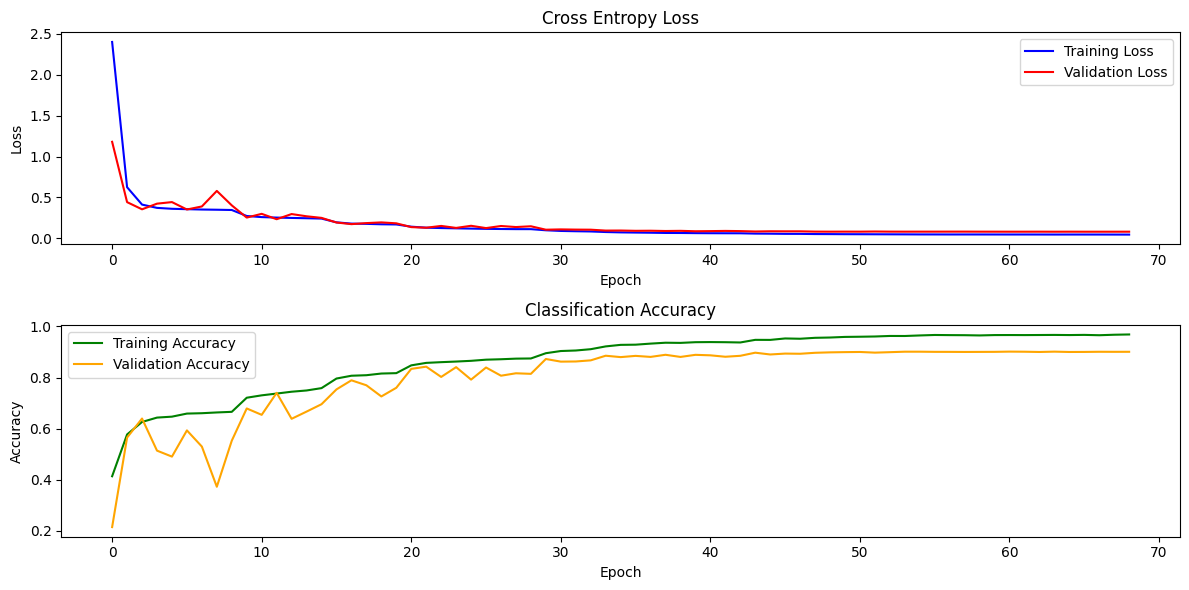

In [18]:
# Plotting the Cross Entropy Loss and Classification Accuracy
plt.figure(figsize=(12, 6))

# Plot Cross Entropy Loss
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(cifar_trained.history['loss'], color='blue', label='Training Loss')
plt.plot(cifar_trained.history['val_loss'], color='red', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Classification Accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(cifar_trained.history['accuracy'], color='green', label='Training Accuracy')
plt.plot(cifar_trained.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


313/313 [==============================] - 1s 2ms/step


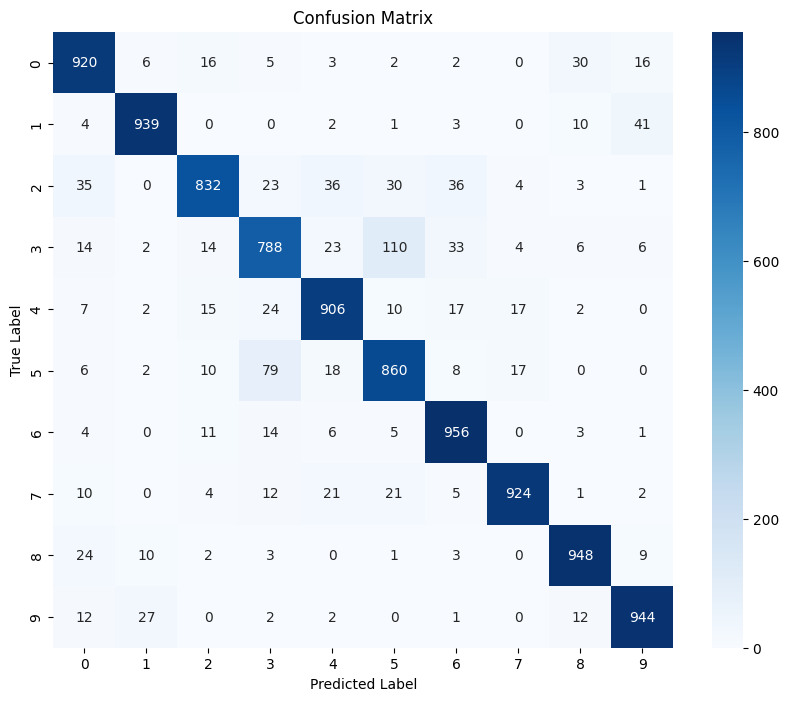

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions and true labels
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
gt = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(gt, predictions)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [20]:
train_loss, train_acc = model.evaluate(x_train, y_train)
print('Test loss:', train_loss)
print('Test accuracy:', train_acc)
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

1563/1563 [==============================] - 5s 3ms/step - loss: 0.0368 - accuracy: 0.9972
Test loss: 0.03680725023150444
Test accuracy: 0.9972000122070312
313/313 [==============================] - 1s 3ms/step - loss: 0.0799 - accuracy: 0.9017
Test loss: 0.079898901283741
Test accuracy: 0.9017000198364258


1/1 [==============================] - 0s 17ms/step


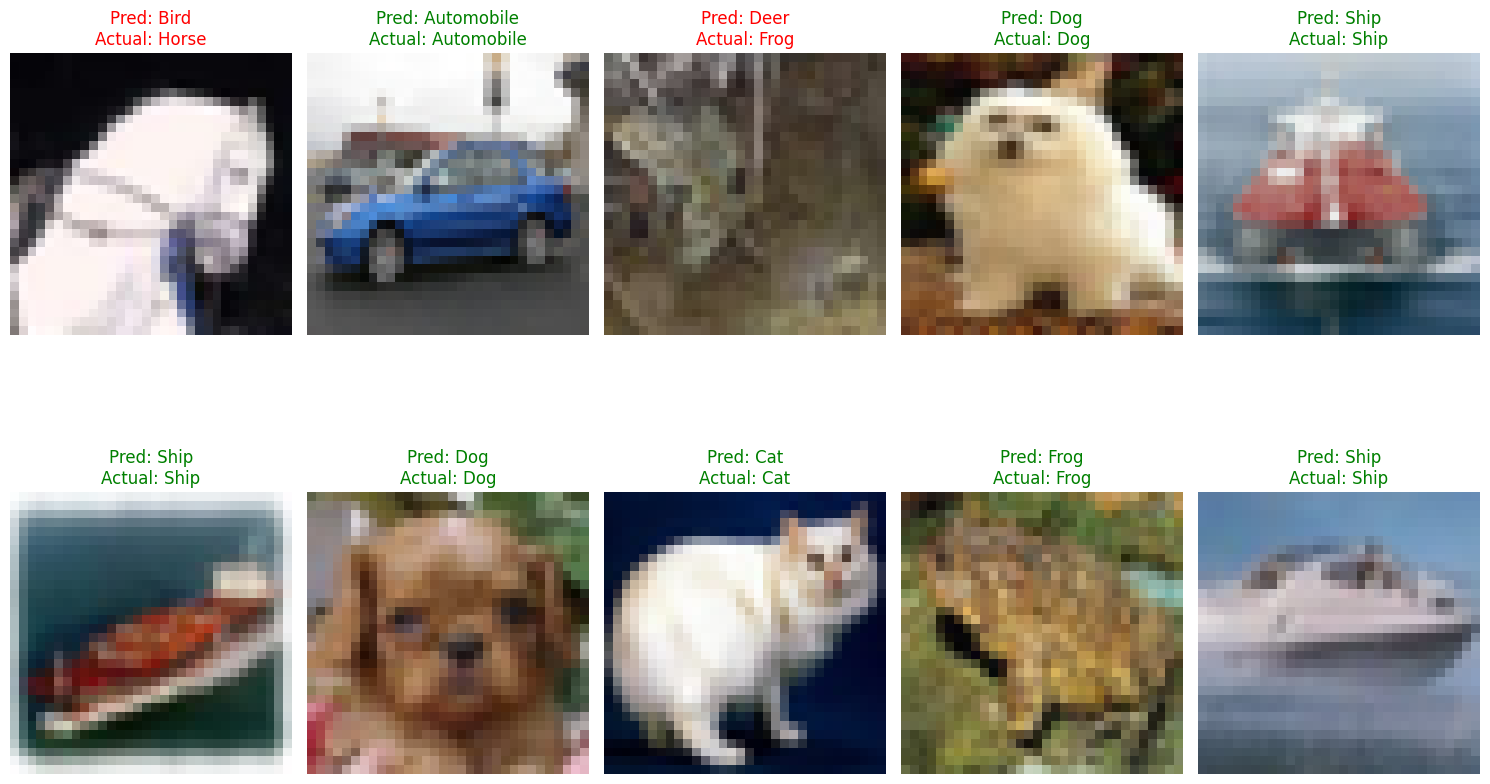

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Class names for CIFAR-10
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Function to display random images with their predictions and actual labels
def display_random_predictions(x_test, y_test, model, class_names):
    # Select 10 random indices from the test set
    random_indices = random.sample(range(x_test.shape[0]), 10)
    
    # Create a figure for plotting
    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(random_indices):
        # Get the actual image and label
        image = x_test[idx]
        actual_label = np.argmax(y_test[idx])
        
        # Predict the class of the image
        prediction = model.predict(np.expand_dims(image, axis=0))  # Expand dimensions to match model input
        predicted_label = np.argmax(prediction[0])
        
        # Plot the image
        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        plt.axis('off')
        
        # Set the title with predicted and actual labels
        title_color = 'green' if predicted_label == actual_label else 'red'  # Green if correct, red if incorrect
        plt.title(f"Pred: {class_names[predicted_label]}\nActual: {class_names[actual_label]}", color=title_color)
    
    plt.tight_layout()
    plt.show()

# Call the function to display the images
display_random_predictions(x_test, y_test, model, class_names)

In [26]:
from keras.backend import clear_session
clear_session()

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation
from tensorflow.keras.applications import ResNet50  # Import the pre-trained ResNet model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 1: Load the pre-trained ResNet model without the top classification layers
base_model = ResNet50(
    weights='imagenet',          # Use weights pre-trained on ImageNet
    include_top=False,           # Do not include the top dense layers of ResNet
    input_shape=(32, 32, 3)      # Set input shape to CIFAR-10 image size
)

# Step 2: Freeze the base model layers to retain the pre-trained features
base_model.trainable = False

for layer in base_model.layers[:20]:  # Adjust the range as needed
    layer.trainable = True
    
# Step 3: Create a Sequential model and add the base ResNet model
model = Sequential([
    base_model,                            # ResNet50 as the base feature extractor
    GlobalAveragePooling2D(),              # Pooling layer to reduce the spatial dimensions
    BatchNormalization(),                  # Normalize the outputs to stabilize learning
    Dense(4000, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(1e-2)), # Custom dense layer
    Dropout(0.5),                          # Dropout for regularization
    BatchNormalization(),    
    Dense(2000, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(1e-2)), # Custom dense layer
    Dropout(0.5),                          # Dropout for regularization
    BatchNormalization(),    
    Dense(1024, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(1e-2)), # Custom dense layer
    Dropout(0.5),                          # Dropout for regularization
    BatchNormalization(),
    Dense(512, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(1e-2)),  # Another dense layer
    Dropout(0.5),
    Dense(10, activation='softmax')        # Output layer with 10 units (one for each class)
])

# Step 4: Compile the model with optimizer, loss, and metrics
model.compile(
    optimizer=Adam(learning_rate=1e-4),   # Adam optimizer
    loss='categorical_crossentropy',       # Categorical Crossentropy loss for multi-class classification
    metrics=['accuracy']
)

# Step 5: Set up callbacks for training
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6),  # Reduce learning rate on plateau
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)     # Early stopping to prevent overfitting
]

datagen = ImageDataGenerator(
    rotation_range=15,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

# Step 7: Train the model with augmented data
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=128),  # Use data augmentation for training
    validation_data=(x_test, y_test),               # Validation data to evaluate the model
    epochs=50,
    callbacks=callbacks                             # Use callbacks to monitor training
)


Epoch 1/50
200/391 [==============>...............] - ETA: 6s - loss: 136.4427 - accuracy: 0.1832

KeyboardInterrupt: 

In [21]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

# Get final training metrics
train_acc = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]

# Get final validation metrics
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]

print(f'Training accuracy: {train_acc:.2f}, loss: {train_loss:.2f}')
print(f'Validation accuracy: {val_acc:.2f}, loss: {val_loss:.2f}')
print(f'Test accuracy: {test_acc:.2f}, loss: {test_loss:.2f}')

Training accuracy: 0.88, loss: 1.14
Validation accuracy: 0.64, loss: 2.04
Test accuracy: 0.64, loss: 1.98


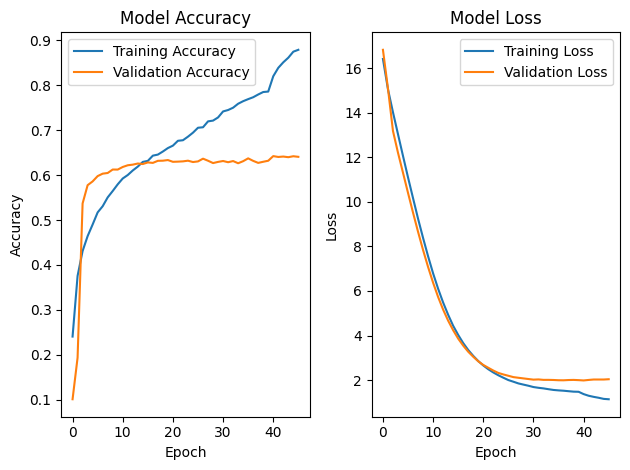

In [23]:
# Plot Cross Entropy Loss curve
# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

313/313 [==============================] - 3s 5ms/step


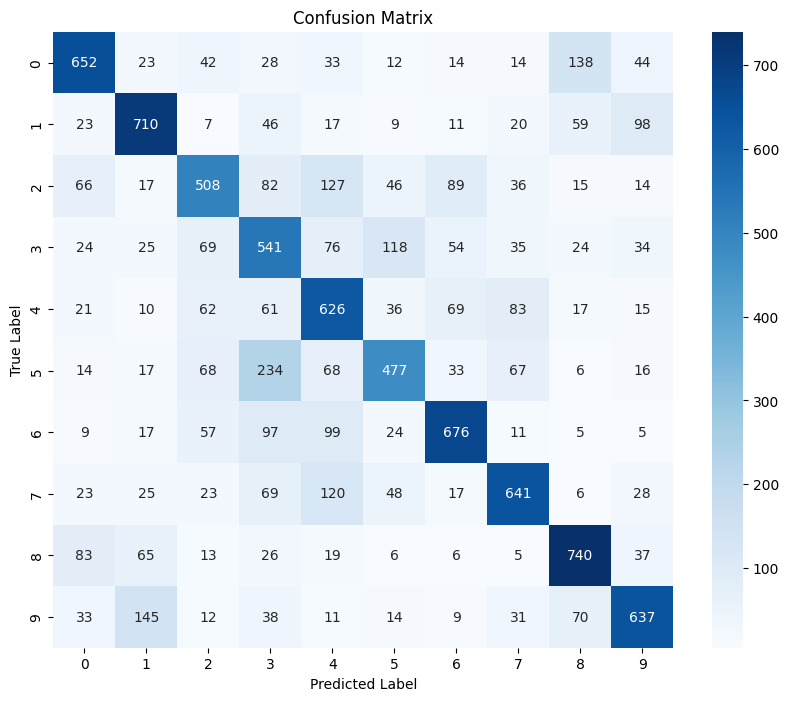

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions and true labels
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
gt = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(gt, predictions)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [4]:
from keras.backend import clear_session
clear_session()

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation
from tensorflow.keras.applications import VGG16  # Import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2


# Step 1: Load the pre-trained VGG16 model without the top classification layers
base_model = VGG16(
    weights='imagenet',  # Use weights pre-trained on ImageNet
    include_top=False,   # Do not include the top fully connected layers of VGG16
    input_shape=(32, 32, 3)  # Input shape adapted to CIFAR-10 image size
)

# Step 2: Freeze the base model layers to retain the pre-trained features
base_model.trainable = False

#for layer in base_model.layers[-24:]:  # Adjust the range as needed
    #layer.trainable = True

# Step 3: Create a Sequential model and add the base VGG16 model
model = Sequential([base_model])

model.add(GlobalAveragePooling2D())    
model.add(BatchNormalization())

model.add(Dense(2048, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))


model.add(Dense(1024, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))

model.add(Dense(512, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-2)))
model.add(BatchNormalization())
model.add(Activation('leaky_relu'))
model.add(Dropout(0.6))

model.add(Dense(512, kernel_regularizer=l2(1e-3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))
model.add(Dense(10, activation='softmax'))
   
   
# Step 4: Compile the model with optimizer, loss, and metrics
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Adam optimizer with a suitable learning rate
    loss='categorical_crossentropy',      # Categorical Crossentropy loss for multi-class classification
    metrics=['accuracy']
)

# Step 5: Set up callbacks for training
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6),  # Reduce learning rate on plateau
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)     # Early stopping to prevent overfitting
]

# Step 7: Train the model with augmented data
history = model.fit(
    x_train, y_train, batch_size=128,  
    validation_data=(x_test, y_test),  # Validation data to evaluate the model
    epochs=50,  # You can adjust this based on how well the model is learning
    callbacks=callbacks  # Use callbacks to monitor training
)

# Step 8: Evaluate the model
val_loss, val_acc = model.evaluate(x_test, y_test)
print(f"Validation Accuracy: {val_acc:.2f}, Validation Loss: {val_loss:.2f}")


58889256/58889256 [==============================] - 1s 0us/step
Epoch 1/50


2024-09-26 14:17:39.265368: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-09-26 14:17:42.905107: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f02e40142f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-26 14:17:42.905114: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-09-26 14:17:42.910173: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1727360262.998955      91 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 [==============================] - 82s 47ms/step - loss: 48.3037 - accuracy: 0.3540 - val_loss: 27.7716 - val_accuracy: 0.6757 - lr: 1.0000e-04
Epoch 2/50
 269/1563 [====>.........................] - ETA: 51s - loss: 25.7835 - accuracy: 0.5701

KeyboardInterrupt: 

In [28]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

# Get final training metrics
train_acc = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]

# Get final validation metrics
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]

print(f'Training accuracy: {train_acc:.2f}, loss: {train_loss:.2f}')
print(f'Validation accuracy: {val_acc:.2f}, loss: {val_loss:.2f}')
print(f'Test accuracy: {test_acc:.2f}, loss: {test_loss:.2f}')

Training accuracy: 0.69, loss: 1.22
Validation accuracy: 0.64, loss: 1.36
Test accuracy: 0.64, loss: 1.36


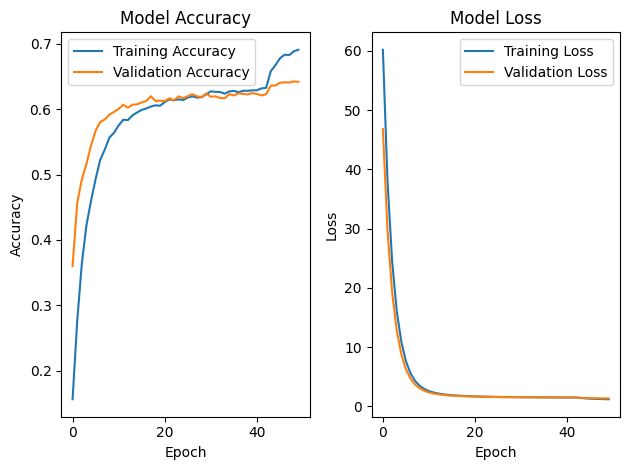

In [29]:
# Plot Cross Entropy Loss curve
# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

313/313 [==============================] - 1s 4ms/step


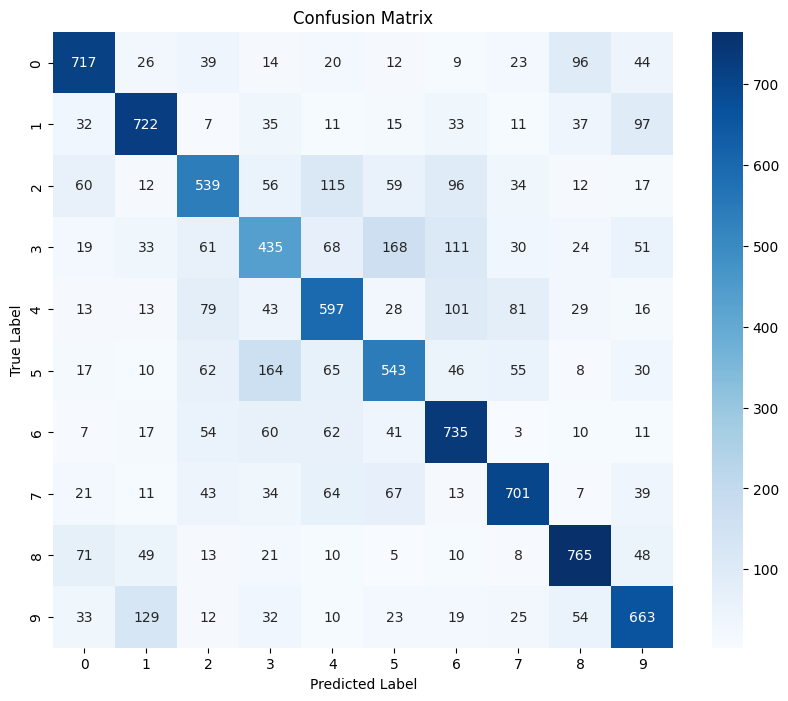

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions and true labels
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
gt = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(gt, predictions)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [6]:
from keras.backend import clear_session
clear_session()

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Preprocess the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)


170498071/170498071 [==============================] - 2s 0us/step


In [3]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Preprocess the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)


In [4]:

def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss function for multi-class classification.
    
    Args:
        gamma (float): Focusing parameter. Higher values put more focus on hard-to-classify samples.
        alpha (float): Balancing factor to reduce the impact of easy negatives and amplify the importance of hard positives.
    
    Returns:
        Loss function to be used with model.compile.
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent log(0) error
        y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        
        # Compute the cross-entropy loss
        ce_loss = -y_true * tf.keras.backend.log(y_pred)
        
        # Calculate the focal loss component
        loss = alpha * tf.keras.backend.pow(1 - y_pred, gamma) * ce_loss
        
        # Return the mean loss across all samples
        return tf.keras.backend.sum(loss, axis=1)
    
    return focal_loss_fixed

In [7]:
# Imports
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, Concatenate, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy


# Data Augmentation setup (optional, you can adjust or skip this if not needed)
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(x_train)

# Define the Fire module used in SqueezeNet
def fire_module(x, squeeze_filters, expand_filters):
    """ Creates a fire module consisting of a squeeze layer followed by an expand layer """
    # Squeeze layer
    squeeze = Conv2D(squeeze_filters, (1, 1), padding='valid', activation='relu')(x)
    squeeze = BatchNormalization()(squeeze)

    # Expand layer
    expand_1x1 = Conv2D(expand_filters, (1, 1), padding='valid', activation='relu')(squeeze)
    expand_1x1 = BatchNormalization()(expand_1x1)
    
    expand_3x3 = Conv2D(expand_filters, (3, 3), padding='same', activation='relu')(squeeze)
    expand_3x3 = BatchNormalization()(expand_3x3)

    # Concatenate the expand paths
    output = Concatenate(axis=-1)([expand_1x1, expand_3x3])
    return output

# Define the SqueezeNet model
def create_squeezenet(input_shape=(32, 32, 3), num_classes=10):
    """ Creates the SqueezeNet model using the Fire modules """
    input_layer = Input(shape=input_shape)

    # Initial Convolutional layer
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    # Fire Modules
    x = fire_module(x, squeeze_filters=16, expand_filters=64)
    x = fire_module(x, squeeze_filters=16, expand_filters=64)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = fire_module(x, squeeze_filters=32, expand_filters=128)
    x = fire_module(x, squeeze_filters=32, expand_filters=128)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = fire_module(x, squeeze_filters=48, expand_filters=192)
    x = fire_module(x, squeeze_filters=48, expand_filters=192)
    x = fire_module(x, squeeze_filters=64, expand_filters=256)
    x = fire_module(x, squeeze_filters=64, expand_filters=256)

    # Final Convolution and Global Average Pooling
    x = Conv2D(num_classes, (1, 1), padding='valid')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax')(x)

    # Create the model
    model = Model(inputs=input_layer, outputs=output)
    return model

# Instantiate the model
model = create_squeezenet()

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy']
)

# Set up callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, min_lr=1e-7),
    EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
]

# Train the model using data augmentation
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=256),
    validation_data=(x_test, y_test),
    epochs=50,
    callbacks=callbacks
)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.2f}, loss: {test_loss:.2f}")


Epoch 1/50


W0000 00:00:1727439386.408868      37 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA RTX A4000" frequency: 1560 num_cores: 48 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 102400 memory_size: 14914027520 bandwidth: 448064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


196/196 [==============================] - 32s 87ms/step - loss: 0.4266 - accuracy: 0.2209 - val_loss: 0.4595 - val_accuracy: 0.1523 - lr: 0.0100
Epoch 2/50
196/196 [==============================] - 16s 79ms/step - loss: 0.3725 - accuracy: 0.2784 - val_loss: 3.6266 - val_accuracy: 0.1000 - lr: 0.0100
Epoch 3/50
196/196 [==============================] - 15s 78ms/step - loss: 0.4036 - accuracy: 0.2194 - val_loss: 0.4399 - val_accuracy: 0.2086 - lr: 0.0100
Epoch 4/50
196/196 [==============================] - 15s 78ms/step - loss: 0.3417 - accuracy: 0.2976 - val_loss: 0.4347 - val_accuracy: 0.2589 - lr: 0.0100
Epoch 5/50
196/196 [==============================] - 15s 78ms/step - loss: 0.3175 - accuracy: 0.3346 - val_loss: 0.3104 - val_accuracy: 0.3432 - lr: 0.0100
Epoch 6/50
196/196 [==============================] - 15s 78ms/step - loss: 0.3039 - accuracy: 0.3522 - val_loss: 0.3007 - val_accuracy: 0.3593 - lr: 0.0100
Epoch 7/50
196/196 [==============================] - 15s 78ms/step -

In [8]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

# Get final training metrics
train_acc = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]

# Get final validation metrics
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]

print(f'Training accuracy: {train_acc:.2f}, loss: {train_loss:.2f}')
print(f'Validation accuracy: {val_acc:.2f}, loss: {val_loss:.2f}')
print(f'Test accuracy: {test_acc:.2f}, loss: {test_loss:.2f}')

Training accuracy: 0.60, loss: 0.17
Validation accuracy: 0.62, loss: 0.16
Test accuracy: 0.62, loss: 0.16


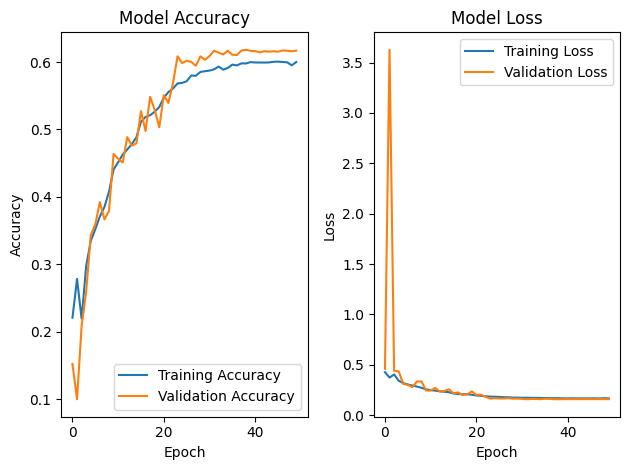

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix# Plot Cross Entropy Loss curve
# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

313/313 [==============================] - 2s 4ms/step


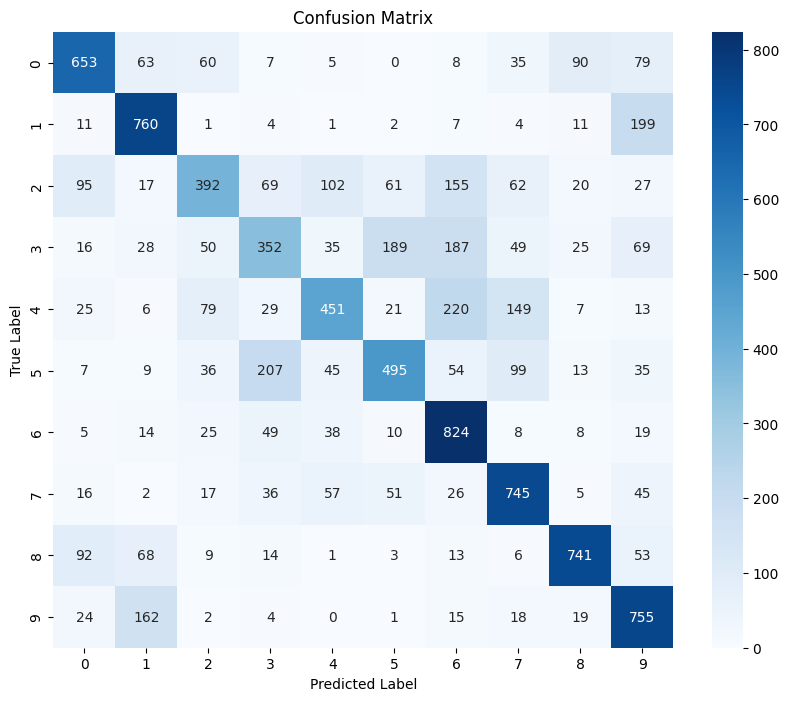

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions and true labels
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
gt = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(gt, predictions)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [11]:
from keras.backend import clear_session
clear_session()